In [ ]:
from google.colab import files
uploaded = files.upload()

Saving INDCPIALLQINMEI.csv to INDCPIALLQINMEI (1).csv
Saving All_India_Index_Upto_Feb24 (1).csv to All_India_Index_Upto_Feb24 (1) (1).csv


In [ ]:
user_csv_path = "All_India_Index_Upto_Feb24 (1).csv"

import pandas as pd

data  = pd.read_csv("All_India_Index_Upto_Feb24 (1).csv")

In [ ]:
data.head()

,Sector,Year,Month,Cereals and products,Meat and fish,Egg,Milk and products,Oils and fats,Fruits,Vegetables,...,Housing,Fuel and light,Household goods and services,Health,Transport and communication,Recreation and amusement,Education,Personal care and effects,Miscellaneous,General index
0,Rural,2013,January,107.5,106.3,108.1,104.9,106.1,103.9,101.9,...,NaN,105.5,104.8,104.0,103.3,103.4,103.8,104.7,104.0,105.1
1,Urban,2013,January,110.5,109.1,113.0,103.6,103.4,102.3,102.9,...,100.3,105.4,104.8,104.1,103.2,102.9,103.5,104.3,103.7,104.0
2,Rural+Urban,2013,January,108.4,107.3,110.0,104.4,105.1,103.2,102.2,...,100.3,105.5,104.8,104.0,103.2,103.1,103.6,104.5,103.9,104.6
3,Rural,2013,February,109.2,108.7,110.2,105.4,106.7,104.0,102.4,...,NaN,106.2,105.2,104.4,103.9,104.0,104.1,104.6,104.4,105.8
4,Urban,2013,February,112.9,112.9,116.9,104.0,103.5,103.1,104.9,...,100.4,105.7,105.2,104.7,104.4,103.3,103.7,104.3,104.3,104.7


In [ ]:
from google.colab import files

# Run this → it will give you a "Choose Files" button
uploaded = files.upload()

In [ ]:
import pandas as pd
import numpy as np
import calendar
from pathlib import Path

# ---------- CONFIG ----------
USER_CSV = "/content/All_India_Index_Upto_Feb24 (1).csv"
FRED_CSV = "/content/INDCPIALLQINMEI.csv"
OUTPUT_CSV = "/content/all_india_cpi_monthly_probabilistic.csv"

START_YEAR = 1970
END_YEAR = 2012
SEED = 42
APPLY_SEASONALITY = True


#--------- LOAD Data------------------------------------
user_df = pd.read_csv(USER_CSV)
fred_df = pd.read_csv(FRED_CSV)

# ---------- PREP FRED -> annual General index ----------
fred_df.columns = [c.strip() for c in fred_df.columns]
fred_df = fred_df.rename(columns={'observation_date': 'DATE', 'INDCPIALLQINMEI': 'index'})
fred_df['DATE'] = pd.to_datetime(fred_df['DATE'])

fred_df = fred_df.set_index('DATE').sort_index()
fred_annual = fred_df.resample('A').mean().reset_index()
fred_annual['Year'] = fred_annual['DATE'].dt.year
fred_annual = fred_annual[['Year','index']].set_index('Year')

# Rebase so 2012 = 100 (use closest available if 2012 missing)
if 2012 in fred_annual.index:
    base_year = 2012
else:
    base_year = min(fred_annual.index, key=lambda y: abs(y-2012))
factor = 100.0 / float(fred_annual.loc[base_year, 'index'])
fred_annual['General index'] = (fred_annual['index'] * factor).round(6)
gen_series = fred_annual['General index'].to_dict()

# ---------- PREP user dataframe ----------
if not {'Sector','Year','Month'}.issubset(user_df.columns):
    raise RuntimeError("User CSV must contain 'Sector', 'Year' and 'Month' columns.")

user_df['Year'] = user_df['Year'].astype(int)
id_cols = ['Sector','Year','Month']
candidate_value_cols = [c for c in user_df.columns if c not in id_cols]

# Coerce numeric
user_numeric = user_df.copy()
for c in candidate_value_cols:
    if user_numeric[c].dtype == object:
        cleaned = user_numeric[c].astype(str).str.replace(',', '', regex=False).str.strip()
        cleaned = cleaned.replace({'': np.nan, 'nan': np.nan, 'NaN': np.nan})
        user_numeric[c] = pd.to_numeric(cleaned, errors='coerce')

numeric_value_cols = [c for c in candidate_value_cols if pd.api.types.is_numeric_dtype(user_numeric[c])]
sectors = user_df['Sector'].unique().tolist()

# ---------- COMPUTE RATIO STATS ----------
recent = user_numeric[user_numeric['Year'] >= 2013].copy()
if 'General index' not in recent.columns:
    recent = recent.merge(fred_annual[['General index']].reset_index(), on='Year', how='left')

annual_user = recent.groupby(['Sector','Year'])[numeric_value_cols].mean().reset_index()
if 'General index' not in annual_user.columns:
    annual_user = annual_user.merge(fred_annual[['General index']].reset_index(), on='Year', how='left')

ratio_stats = {}
for sector in sectors:
    ratio_stats[sector] = {}
    sdf = annual_user[annual_user['Sector']==sector].dropna(subset=['General index'])
    for col in numeric_value_cols:
        if col == 'General index':
            continue
        vals = sdf[[col,'General index']].dropna()
        if vals.empty:
            ratio_stats[sector][col] = (1.0, 0.05)
            continue
        ratios = vals[col] / vals['General index']
        mu, sigma = float(ratios.mean()), float(ratios.std(ddof=0))
        if np.isnan(sigma) or sigma < 1e-4:
            sigma = max(0.01, 0.01 * abs(mu))
        ratio_stats[sector][col] = (mu, sigma)

# ---------- SEASONAL FACTORS ----------
month_names = list(calendar.month_name)[1:]
season_factors = {}
if APPLY_SEASONALITY:
    season_factors = {s:{} for s in sectors}
    for sector in sectors:
        sec_df = recent[recent['Sector']==sector]
        for col in numeric_value_cols:
            temp = sec_df[[col,'Year','Month']].dropna() if col in sec_df.columns else pd.DataFrame()
            if temp.empty:
                season_factors[sector][col] = {m:1.0 for m in month_names}
                continue
            monthly_mean = temp.groupby('Month')[col].mean()
            annual_mean = temp.groupby('Year')[col].mean().mean()
            if pd.isna(annual_mean) or abs(annual_mean) < 1e-6:
                season_factors[sector][col] = {m:1.0 for m in month_names}
                continue
            raw = {m: (monthly_mean.get(m, annual_mean) / annual_mean) for m in month_names}
            mean_raw = np.mean(list(raw.values()))
            season_factors[sector][col] = {m: float(raw[m]/mean_raw) for m in month_names}

# ---------- SYNTHETIC GENERATION ----------
np.random.seed(SEED)
synthetic_rows = []
for sector in sectors:
    for year in range(START_YEAR, END_YEAR+1):
        gen_val = float(gen_series[year])
        annual_values = {}
        for col in numeric_value_cols:
            if col == 'General index':
                annual_values[col] = float(round(gen_val,6))
                continue
            mu,sigma = ratio_stats[sector].get(col, (1.0, 0.05))
            for _ in range(10):
                r = np.random.normal(mu, sigma)
                if r > 0:
                    break
            else:
                r = max(0.01, mu)
            annual_values[col] = float(gen_val * r)
        for m in month_names:
            row = {'Sector': sector, 'Year': year, 'Month': m}
            for col,v in annual_values.items():
                if APPLY_SEASONALITY and col in season_factors[sector]:
                    row[col] = float(v * season_factors[sector][col].get(m,1.0))
                else:
                    row[col] = float(v)
            synthetic_rows.append(row)

synthetic_df = pd.DataFrame(synthetic_rows)

# ---------- CONCAT ----------
observed_df = user_df[user_df['Year'] >= 2013].copy()
if 'General index' not in observed_df.columns:
    observed_df = observed_df.merge(fred_annual[['General index']].reset_index(), on='Year', how='left')

ordered_cols = id_cols + numeric_value_cols
for c in ordered_cols:
    if c not in observed_df.columns: observed_df[c] = pd.NA
for c in ordered_cols:
    if c not in synthetic_df.columns: synthetic_df[c] = pd.NA
observed_df = observed_df[ordered_cols]
synthetic_df = synthetic_df[ordered_cols]

final = pd.concat([synthetic_df, observed_df], axis=0, ignore_index=True)
final['Month'] = pd.Categorical(final['Month'], categories=month_names, ordered=True)
final = final.sort_values(['Sector','Year','Month']).reset_index(drop=True)

# ---------- SAVE ----------
final.to_csv(OUTPUT_CSV, index=False)
print("Done. Saved:", OUTPUT_CSV, " Rows:", len(final))
final.shape
 #Hello world

/tmp/ipython-input-4256009076.py:27: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  fred_annual = fred_df.resample('A').mean().reset_index()


Done. Saved: /content/all_india_cpi_monthly_probabilistic.csv  Rows: 1947


(1947, 30)

In [ ]:
from google.colab import files

files.download("/content/all_india_cpi_monthly_probabilistic.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Numeric columns detected (sample): ['Cereals and products', 'Meat and fish', 'Egg', 'Milk and products', 'Oils and fats', 'Fruits', 'Vegetables', 'Pulses and products']
Plotting seasonality for: ['General index', 'Meat and fish', 'Vegetables', 'Pan, tobacco and intoxicants']


/tmp/ipython-input-1534505486.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly = sector_df.groupby('Month')[col].mean().reindex(month_names)
/tmp/ipython-input-1534505486.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly = sector_df.groupby('Month')[col].mean().reindex(month_names)
/tmp/ipython-input-1534505486.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly = sector_df.groupby('Month'

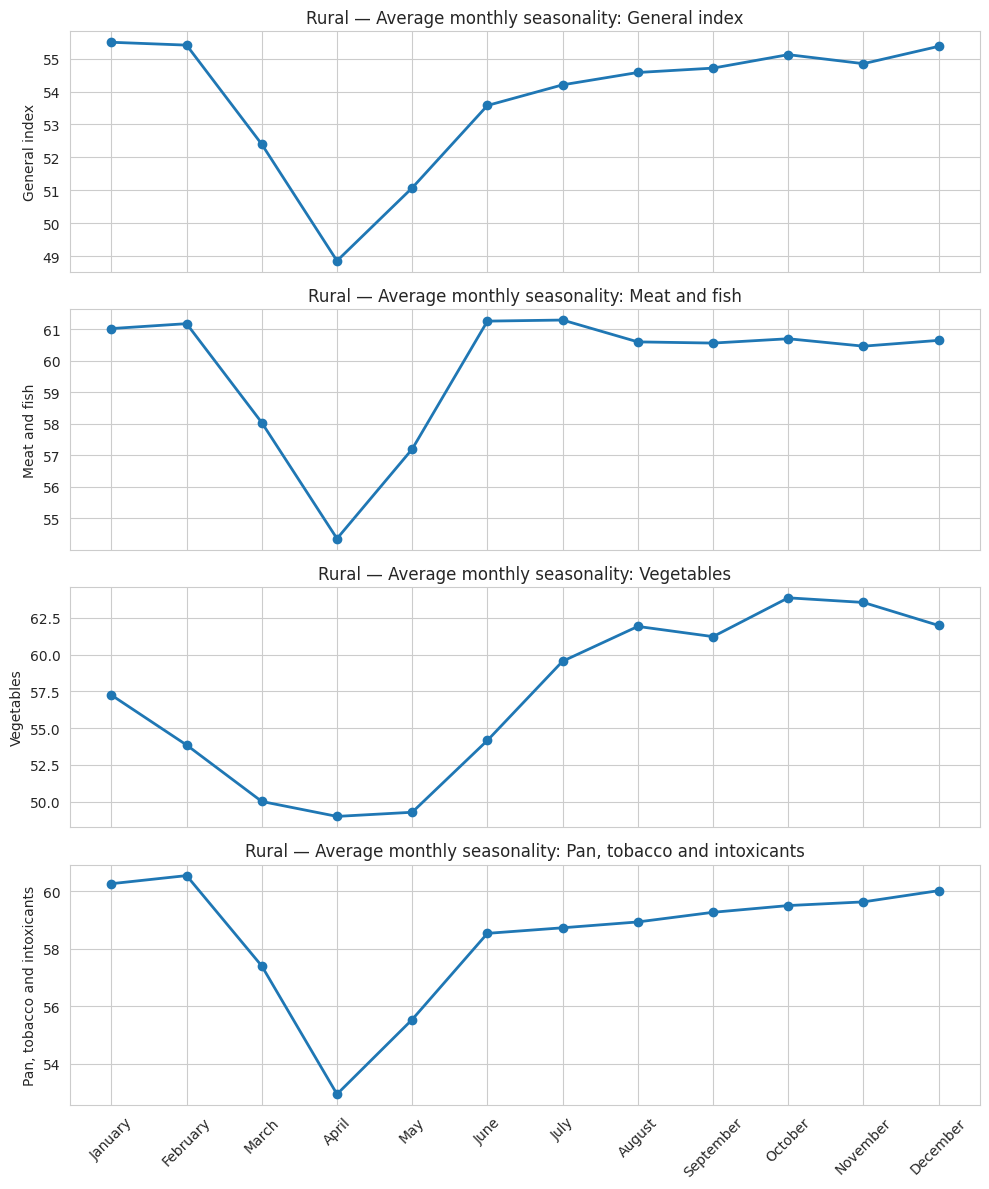

/tmp/ipython-input-1534505486.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly = sector_df.groupby('Month')[col].mean().reindex(month_names)
/tmp/ipython-input-1534505486.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly = sector_df.groupby('Month')[col].mean().reindex(month_names)
/tmp/ipython-input-1534505486.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly = sector_df.groupby('Month'

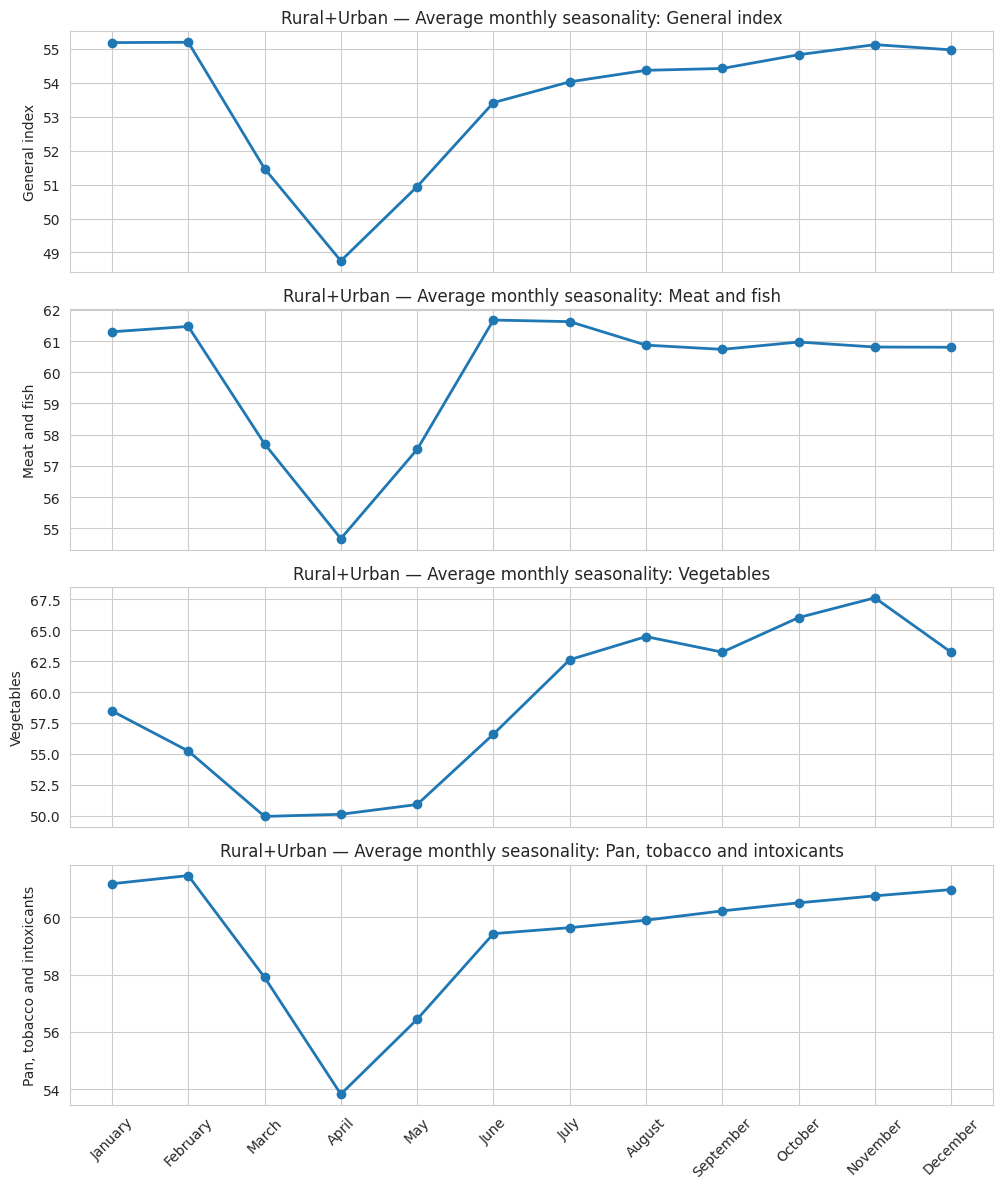

/tmp/ipython-input-1534505486.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly = sector_df.groupby('Month')[col].mean().reindex(month_names)
/tmp/ipython-input-1534505486.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly = sector_df.groupby('Month')[col].mean().reindex(month_names)
/tmp/ipython-input-1534505486.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly = sector_df.groupby('Month'

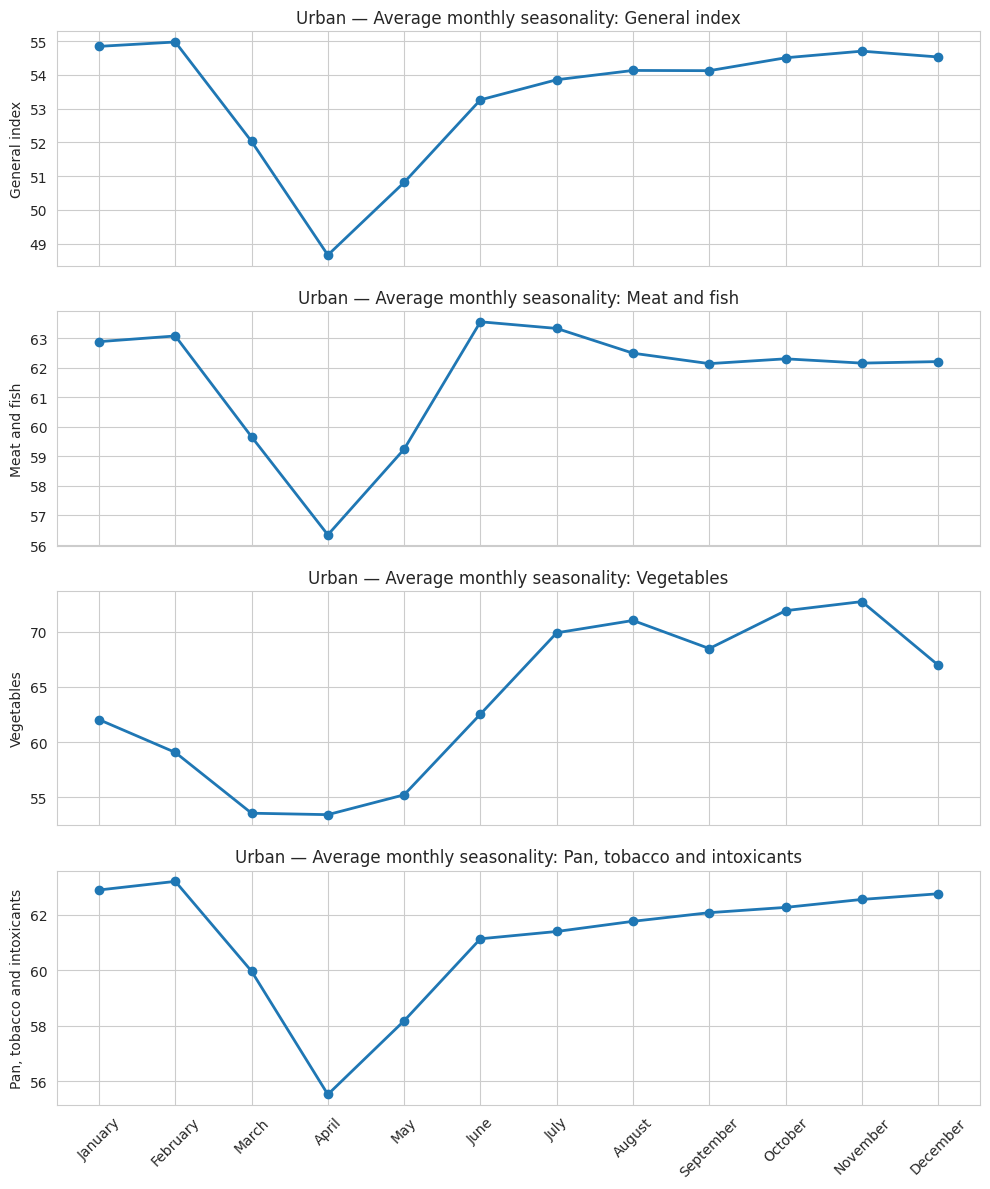

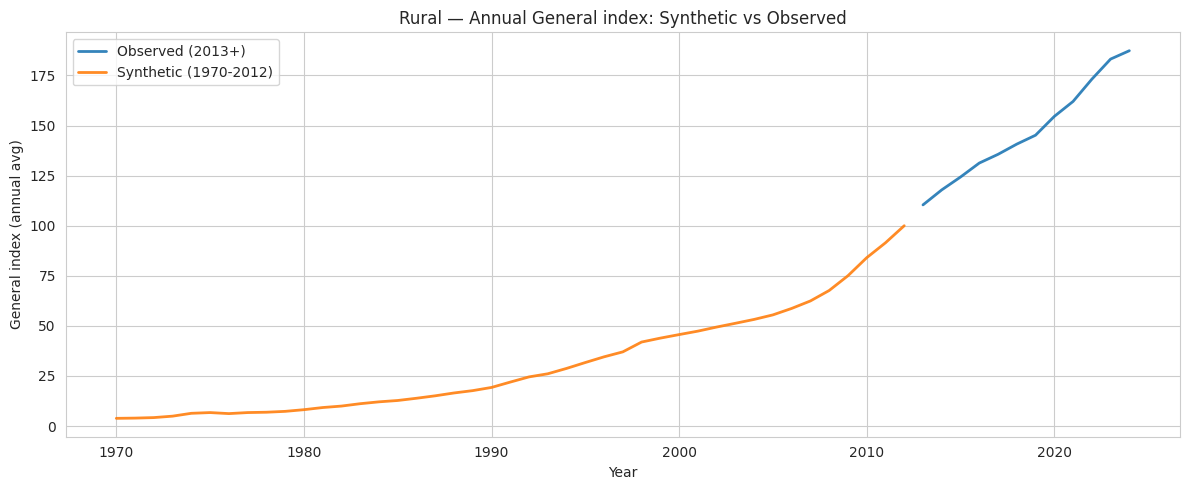

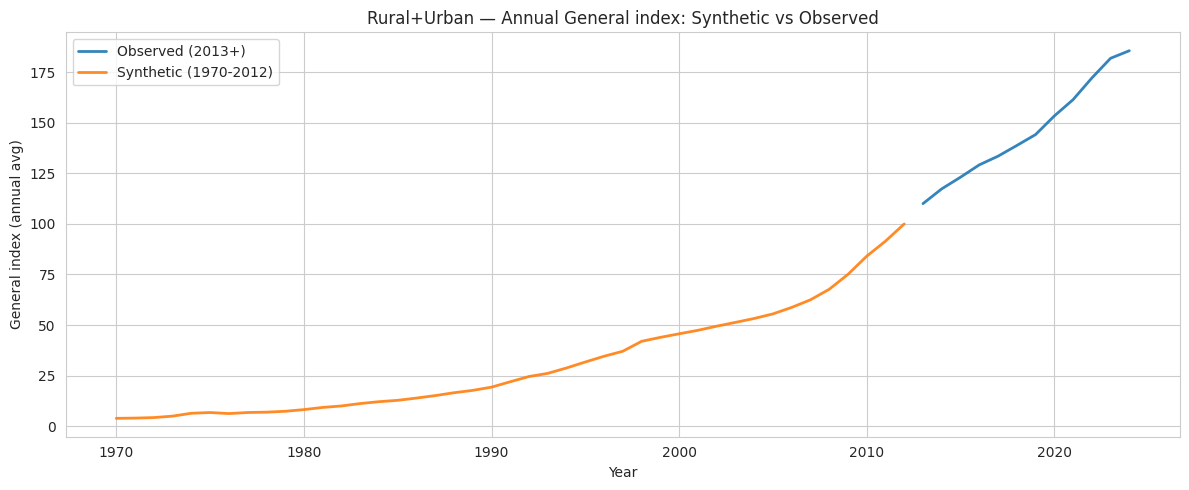

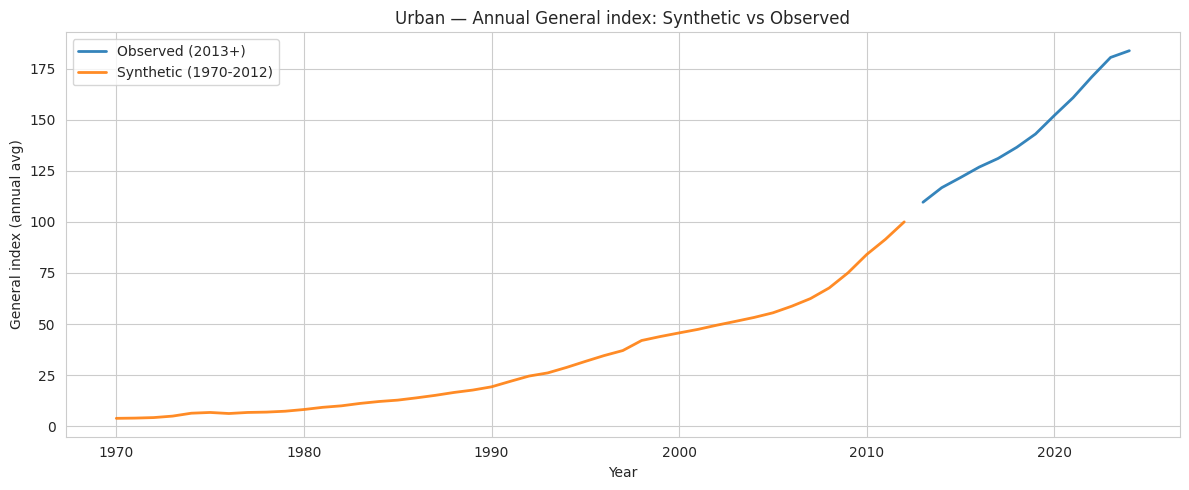

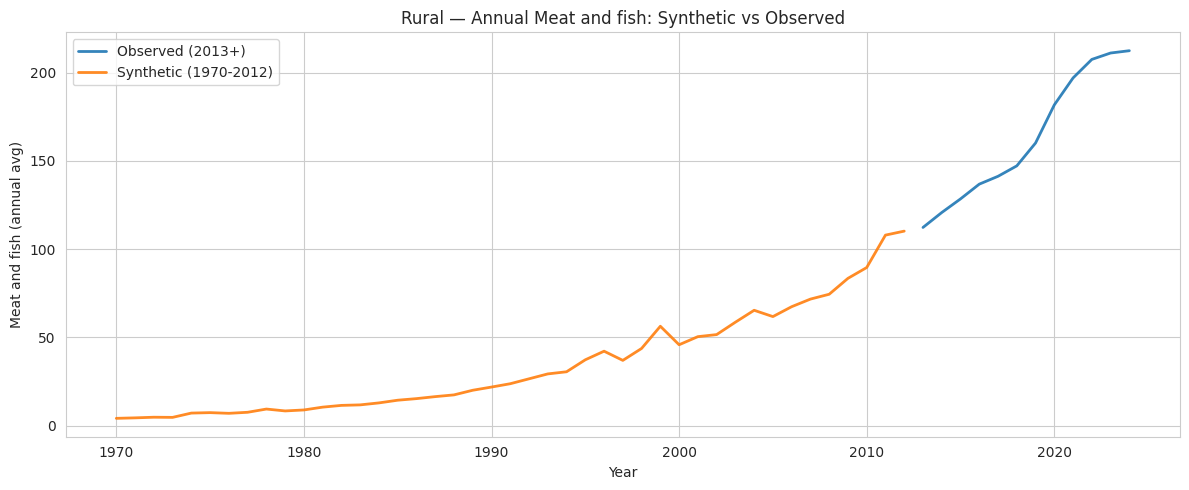

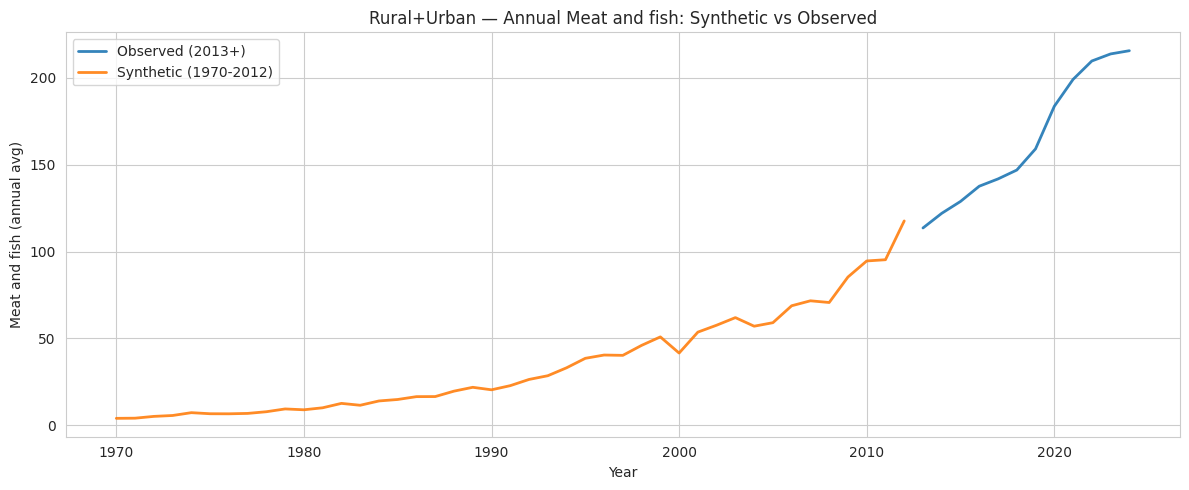

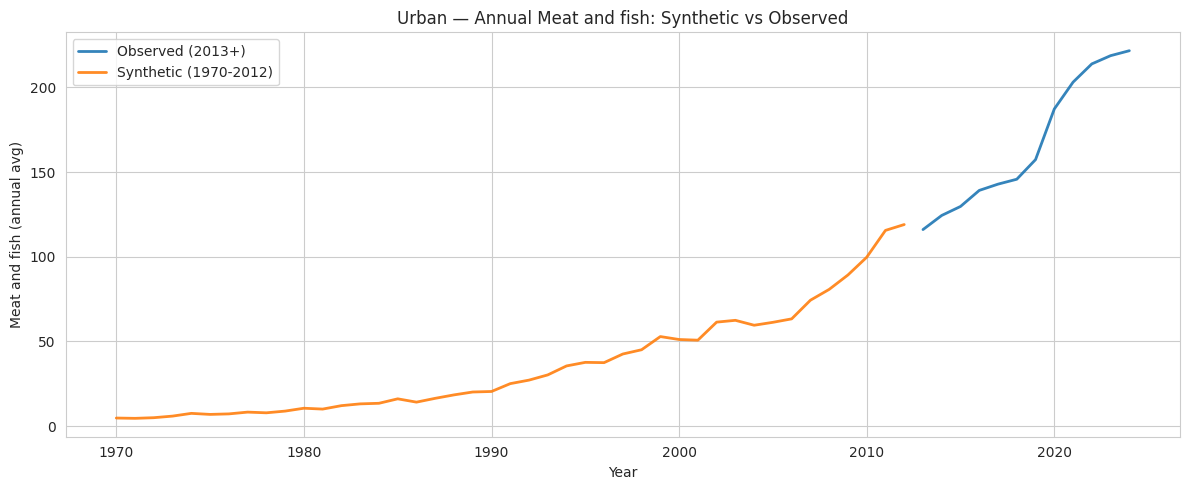

Plots saved to: /content/eda_plots


In [ ]:
# EDA plots: seasonality + synthetic vs observed comparison
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style("whitegrid")
DATA_CSV = "/content/all_india_cpi_monthly_probabilistic.csv"
OUT_DIR = Path("/content/eda_plots")
OUT_DIR.mkdir(exist_ok=True)

# Load
df = pd.read_csv(DATA_CSV)
# Ensure Month is categorical ordered Jan..Dec
month_names = list(__import__("calendar").month_name)[1:]
df['Month'] = pd.Categorical(df['Month'], categories=month_names, ordered=True)

# Identify numeric columns (exclude id cols)
id_cols = ['Sector','Year','Month']
num_cols = [c for c in df.columns if c not in id_cols and pd.api.types.is_numeric_dtype(df[c])]
if 'General index' not in num_cols and 'General index' in df.columns:
    num_cols = ['General index'] + [c for c in num_cols if c!='General index']

print("Numeric columns detected (sample):", num_cols[:8])

# 1) Monthly seasonality: average by Month for each Sector and selected variables
# We'll plot General index + top 3 numeric categories by variance
var_scores = df[num_cols].var().sort_values(ascending=False)
top_cats = var_scores.index.drop('General index', errors='ignore').tolist()[:3]
plot_cols = ['General index'] + top_cats
print("Plotting seasonality for:", plot_cols)

for sector in df['Sector'].unique():
    fig, axes = plt.subplots(len(plot_cols), 1, figsize=(10, 3*len(plot_cols)), sharex=True)
    sector_df = df[df['Sector']==sector]
    for i,col in enumerate(plot_cols):
        monthly = sector_df.groupby('Month')[col].mean().reindex(month_names)
        ax = axes[i] if len(plot_cols)>1 else axes
        ax.plot(month_names, monthly.values, marker='o', linewidth=2)
        ax.set_title(f"{sector} — Average monthly seasonality: {col}")
        ax.set_ylabel(col)
        ax.set_xticks(month_names)
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    outp = OUT_DIR / f"seasonality_{sector.replace(' ','_')}.png"
    plt.savefig(outp, bbox_inches="tight", dpi=200)
    plt.show()

# 2) Synthetic vs Observed comparison (annual averages)
# We assume synthetic = years <= 2012; observed = years >= 2013
df['DataType'] = np.where(df['Year'] <= 2012, 'Synthetic (1970-2012)', 'Observed (2013+)')
annual = df.groupby(['DataType','Year','Sector'])[num_cols].mean().reset_index()

# Plot General index annual time series, color by DataType
for sector in df['Sector'].unique():
    sec = annual[annual['Sector']==sector]
    plt.figure(figsize=(12,5))
    for dtype, g in sec.groupby('DataType'):
        plt.plot(g['Year'], g['General index'], label=dtype, linewidth=2, alpha=0.9)
    plt.title(f"{sector} — Annual General index: Synthetic vs Observed")
    plt.xlabel("Year")
    plt.ylabel("General index (annual avg)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    outp = OUT_DIR / f"genindex_synthetic_vs_observed_{sector.replace(' ','_')}.png"
    plt.savefig(outp, bbox_inches="tight", dpi=200)
    plt.show()

# Pick a sample category to compare (top variance category)
sample_category = top_cats[0] if top_cats else (num_cols[1] if len(num_cols)>1 else None)
if sample_category:
    for sector in df['Sector'].unique():
        sec = annual[annual['Sector']==sector]
        plt.figure(figsize=(12,5))
        for dtype, g in sec.groupby('DataType'):
            plt.plot(g['Year'], g[sample_category], label=dtype, linewidth=2, alpha=0.9)
        plt.title(f"{sector} — Annual {sample_category}: Synthetic vs Observed")
        plt.xlabel("Year")
        plt.ylabel(sample_category + " (annual avg)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        outp = OUT_DIR / f"{sample_category}_synthetic_vs_observed_{sector.replace(' ','_')}.png"
        plt.savefig(outp, bbox_inches="tight", dpi=200)
        plt.show()
else:
    print("No sample category available for synthetic vs observed comparison.")

print("Plots saved to:", OUT_DIR)
